In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from tqdm import tqdm
from attack_utils import *
from dataset_utils import *
from MoPe import MoPe
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
mod_size = "70m"
model_title = f"pythia-{mod_size}-deduped"
model_name = "EleutherAI/" + model_title
model_revision = "step98000"
model_cache_dir = "./"+ model_title +"/"+model_revision

In [3]:
training_dataset = load_train_pile_random(number=5000,seed=229,num_splits=1)[0]
validation_dataset = load_val_pile(number=5000, seed=229, num_splits=1)[0]

Warning! Shadow models requires an even number of splits! You specified 1 splits.


Found cached dataset parquet (/home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ea5dcc659448d52f.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-309796835bdc8901.arrow
No config specified, defaulting to: the_pile_val/all
Found cached dataset the_pile_val (/home/ec2-user/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30)
Loading cac

Warning! If using shadow models, use an even number of splits! You specified 1 splits.


In [4]:
model = GPTNeoXForCausalLM.from_pretrained(model_name,revision=model_revision,cache_dir=model_cache_dir)
max_length = model.config.max_position_embeddings
del model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")

Seed 3647036022913499433
Memory usage after creating new model #0
Total Memory: 15.77 GB
Reserved Memory: 0.36 GB (2.27%)
Remaining Memory: 15.41 GB (97.73%)
---------------------------------
Allocated Memory: 0.16 GB (1.01%)
Percent of Reserved Allocated: 44.56%

Seed 3331874132779640167
Memory usage after creating new model #1
Total Memory: 15.77 GB
Reserved Memory: 0.36 GB (2.27%)
Remaining Memory: 15.41 GB (97.73%)
---------------------------------
Allocated Memory: 0.16 GB (1.01%)
Percent of Reserved Allocated: 44.56%

Seed 11945757464747896321
Memory usage after creating new model #2
Total Memory: 15.77 GB
Reserved Memory: 0.36 GB (2.27%)
Remaining Memory: 15.41 GB (97.73%)
---------------------------------
Allocated Memory: 0.16 GB (1.01%)
Percent of Reserved Allocated: 44.56%



  0%|          | 0/5000 [00:00<?, ?it/s]/home/ec2-user/unlearning-large/dataset_utils.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
  2%|▏         | 100/5000 [00:02<01:43, 47.16it/s]
/home/ec2-user/unlearning-large/attack_utils.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/home/ec2-user/unlearning-large/attack_utils.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statist

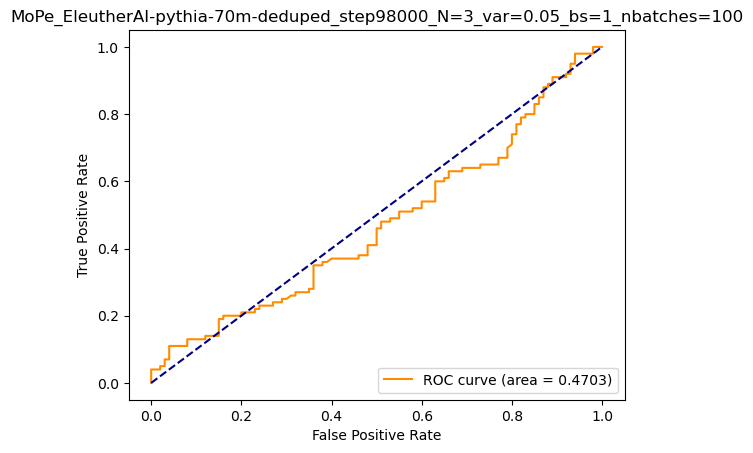

/home/ec2-user/unlearning-large/attack_utils.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/home/ec2-user/unlearning-large/attack_utils.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statistic).flatten()


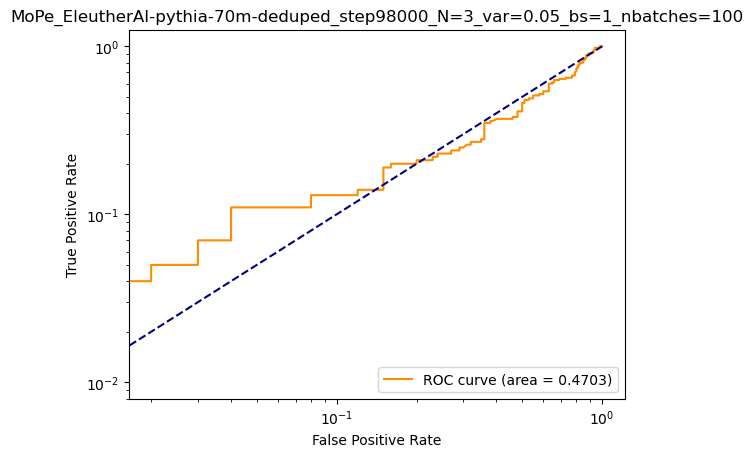

In [5]:
training_dataloader = DataLoader(training_dataset, batch_size = 1, collate_fn=lambda batch: collate_fn(batch, tokenizer=tokenizer, length=max_length))
validation_dataloader = DataLoader(validation_dataset, batch_size = 1, collate_fn=lambda batch: collate_fn(batch, tokenizer=tokenizer, length=max_length))

config_mope = {
    "training_dl": training_dataloader,
    "validation_dl": validation_dataloader,
    "n_new_models": 3,
    "noise_variance": 0.05,
    "bs" : 1,
    "nbatches": 100,
    "samplelength": None,
    "device": device
}

MoPer = MoPe(model_name, model_revision=model_revision, cache_dir=model_cache_dir)
MoPer.inference(config_mope)

MoPer.attack_plot_ROC(log_scale = False)
MoPer.attack_plot_ROC(log_scale = True)